In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time as timing
import os
#from Edited_Photons_for_any_TTBIN import Photons
import random
import math
from numba import jit
from scipy.stats import poisson

def coherence_length(wavelength_nm, delta_lambda_nm):
    # Convert wavelength from nm to meters
    wavelength_m = wavelength_nm * 1e-9
    
    # Convert delta_lambda from nm to meters
    delta_lambda_m = delta_lambda_nm * 1e-9
    
    # Calculate coherence length
    coherence_length_m = (wavelength_m ** 2) / (np.pi * delta_lambda_m)
    
    # Convert coherence length from meters to nm
    coherence_length_nm = coherence_length_m * 1e9
    
    return coherence_length_nm



#this function assigns photons to channels the arrival time array has been created 
@jit(nopython=True)
def process_photon_arr(photon_arr, p1, random_number, buffer_size):
    photon_number = photon_arr.shape[0]
    for buffer in range(1, int(photon_number / buffer_size) + 1):
        upper_index = buffer * buffer_size
        lower_index = (buffer - 1) * buffer_size

        temp_arr = p1[lower_index:upper_index].reshape(-1, 1)

        mask = random_number[lower_index:upper_index] > temp_arr

        temp_photon_arr = photon_arr[lower_index:upper_index]
        mask = np.squeeze(mask)

        temp_photon_arr[mask, 0] = 2
        photon_arr[lower_index:upper_index] = temp_photon_arr

    return photon_arr

#this function will assign frequencies to photons given two specific frequencies
@jit
def assign_freq_for_binaryfreq(photon_number,sequence_length, ensamble_size, freq_array,top_freq, bot_freq):
    for j in range(0,photon_number,int(sequence_length)):
        binomial_number = np.random.binomial( ensamble_size, .5, size=1)
        index0 = j
        index1 = int(j+sequence_length)
        
        prob = binomial_number/ ensamble_size
    
        for k in range(len(freq_array[index0:index1])):
            #change every other value to be 600 or 650c
            random_number = random.uniform(0,1)
         
            if random_number > prob:
                freq_array[index0+k] = bot_freq
            else:
                freq_array[index0+k] = top_freq
'''Old assignment function'''
def assign_gaussian_frequency_old(photon_number, sequence_length, ensamble_size, freq_array, top_freq ,bot_freq, std_dev):
    for j in range(0,photon_number,int(sequence_length)):
        index0 = j
        index1 = int(j+sequence_length)
        binomial_number = np.random.binomial( ensamble_size, .5, size=1)
        prob = binomial_number/ ensamble_size
        
        
        random_number = random.uniform(0,1)
      
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=int(sequence_length))
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=int(sequence_length))
            


@jit
def assign_gaussian_frequency(photon_number, sequence_length, ensemble_size, freq_array, top_freq, bot_freq, std_dev):
    for j in range(0, photon_number - sequence_length + 1, sequence_length):
        index0 = j
        index1 = j + sequence_length
        binomial_number = np.random.binomial(ensemble_size, 0.5, size=1)
        prob = binomial_number / ensemble_size
        random_number = random.uniform(0, 1)
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=sequence_length)
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=sequence_length)
    
    # Handle remaining photons
    remaining_photons = photon_number % sequence_length
    if remaining_photons > 0:
        index0 = photon_number - remaining_photons
        index1 = photon_number
        binomial_number = np.random.binomial(ensemble_size, 0.5, size=1)
        prob = binomial_number / ensemble_size
        random_number = random.uniform(0, 1)
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=remaining_photons)
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=remaining_photons)


def assign_gaussian_frequency_v2(sequence_length, total_time, time_array, photon_number, expected_oscillations):
    time_freq_array = np.random.choice([top_freq, bot_freq], size=int(expected_oscillations))
    print(expected_oscillations)
    
    # Compute indices for frequency assignment
    indices = (time_array // (total_time * 1e12 / expected_oscillations)) % len(time_freq_array)
    
    # Use indices to assign frequencies with random noise
    freq_array = np.random.normal(time_freq_array[indices.astype(int)], std_dev)
    
    return freq_array


            

@jit
def assign_gaussian_frequency_soft_switching(detector_resolution,probability_per_bin,sequence_length, total_time, time_array, photon_number, expected_oscillations):
    switching_arr = np.zeros((2,int(expected_oscillations)))
    
    switching_arr[0,:] = np.sort(np.random.uniform(0,total_time*1e12, size=int(expected_oscillations)))
    switching_arr[1,:] = np.random.choice(np.array([top_freq, bot_freq]), size=int(expected_oscillations))
    
    indices = np.searchsorted(switching_arr[0, :], time_array, side='right') 
    freq_arr = np.zeros(photon_number)
    # Draw from a Gaussian distribution for each center frequency
    for i in range(photon_number):
        # Get the center frequency corresponding to the index
        index = indices[i]
     
        center_frequency = switching_arr[1, index]
        # Draw from a Gaussian distribution with center frequency as mean
        freq_arr[i] = np.random.normal(center_frequency, std_dev)
        
    return freq_arr, switching_array

@jit
def assign_gaussian_frequency_soft_switching_mulitplexed(detector_resolution,probability_per_bin,sequence_length, total_time, time_array, photon_number, expected_oscillations,switching_arr):
    indices = np.searchsorted(switching_arr[0, :], time_array, side='right') 
    freq_arr = np.zeros(photon_number)
    # Draw from a Gaussian distribution for each center frequency
    for i in range(photon_number):
        # Get the center frequency corresponding to the index
        index = indices[i]
     
        center_frequency = switching_arr[1, index]
        # Draw from a Gaussian distribution with center frequency as mean
        freq_arr[i] = np.random.normal(center_frequency, std_dev)
        
    return freq_arr
        
'''
these two functions have different perfomances but essentially do the same thing. It is better to use the first with large photon numner usually
and better to use the second with small photon number and or small bin size. I would test them to see what works best for your combination of detector 
resolution and photon number. the second usually works better If you arent at or near the array memory limit for time_arr
'''
@jit(nopython=True)
def simulate_arrival_time(time_arr, PPS, total_time, detector_resolution, probability_per_bin):
    for i in range(1, PPS * total_time):
        passed_bins = 1
        while time_arr[i] == 0:
            random_number = random.random()

            if probability_per_bin > random_number:
                time_arr[i] = time_arr[i - 1] + passed_bins * detector_resolution
            else:
                passed_bins += 1
                
@jit(nopython=True)
def simulate_arrival_time_alternate(time_arr, photon_number, total_time, detector_resolution, number_of_bins):
    for i in range(1, photon_number):
        arrival_bin = random.randint(0, int(number_of_bins))
     
        time_arr[i] = arrival_bin*detector_resolution
    time_arr_sorted = np.sort(time_arr)
    return time_arr_sorted

def arrival_time_vectorized(photon_number,total_time):
    time_arr = np.random.uniform(0, total_time*1e12, size=int(photon_number))
    return np.sort(time_arr)

def simulate_arrival_time_gamma(photon_number,probability_per_bin,detector_resolution):
    arrival_times = np.random.gamma(shape=1, scale=1/probability_per_bin, size=int(photon_number))
    arrival_times = np.cumsum(arrival_times) *detector_resolution
    return arrival_times


#writes stage positions in an exponential manner
def exp_spacing_position(number_of_pos, final_pos, stage_position):
    
    x = final_pos**(1/number_of_pos)
    
    for i in range(0,number_of_pos+1):
        new_pos = x**i
        stage_position.append(new_pos)
#writes stage positions in a linear manner
def linear_spacing_position(number_of_pos, final_pos, stage_position):
    x = final_pos/number_of_pos
    for i in range(number_of_pos):
        a = i
        new_pos = x*a
        stage_position.append(new_pos)
        

In [2]:

def convert_wn_to_wl(reighliegh_wavelength,raman_wavenumber,linewidth_cm, freq_jump_cm):
    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)
    #cm -1 to nm conversion 
    #for single conversion s

    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)

    #compute the nm shift for inverse cm shifts
    center_peak1 = raman_wavenumber
    upper_end1 = center_peak1+linewidth_cm/2
    lower_end1 = center_peak1-linewidth_cm/2
    upper_nm1 = 1e7/(1e7/reighliegh_wavelength-upper_end1)
    lower_nm1= 1e7/(1e7/reighliegh_wavelength-lower_end1)

    #linewidth in nm 
    linewidth_nm = (upper_nm1-lower_nm1)/2

    #compute the nm shift for inverse cm shifts
 
    center_peak = raman_wavenumber
    upper_end = center_peak+freq_jump_cm
    lower_end = center_peak
    upper_nm = 1e7/(1e7/reighliegh_wavelength-upper_end)
    lower_nm = 1e7/(1e7/reighliegh_wavelength-lower_end)

    #linewidth in nm 
    nm_shift = upper_nm-lower_nm

    return (raman_wavelength, nm_shift, linewidth_nm)


print(convert_wn_to_wl(reighliegh_wavelength = 633,raman_wavenumber = 810,linewidth_cm = 1.5, freq_jump_cm = 4))


raman_wavelength, nm_shift, linewidth_nm = convert_wn_to_wl(reighliegh_wavelength = 633,raman_wavenumber = 1106,linewidth_cm = 1.5, freq_jump_cm = 4)#1.5,4

mode_2, nm_shift2, _ = convert_wn_to_wl(reighliegh_wavelength = 633,raman_wavenumber = 847,linewidth_cm =1.5, freq_jump_cm = 6)#1.5,6

print(mode_2)

(667.2098506735867, 0.1781151300020838, 0.03338767394632214)
668.8610521997973


In [3]:

total_start = timing.time()

%run jupyter_photons_code.ipynb


correlation_arr = []
#what directory and filename to store the .photons file
 
directory = '/global/scratch/projects/co_utzatgroup/ccobbbruno/24_05_14_multiplexing_with_fewer_stagepositions/Anticorrelated_generalized/'
#open the file for the position documentation
pos_file_name = directory + os.sep +'posFile.pos'
pcfs_file_name = directory + os.sep +'position.pcfslog'
pos_file = open(pos_file_name,'w')
pcfs_log_file = open(pcfs_file_name, 'w')

'''
===============================================================================================================
===============================================================================================================
'''
top_freq = raman_wavelength
bot_freq = raman_wavelength+nm_shift
std_dev = linewidth_nm
correlation_state = 'anti-correlated'
center_frequency_difference = raman_wavelength-mode_2
second_mode_shift = nm_shift2
print(top_freq)
print(bot_freq)
print(std_dev)

ensamble_size = 1
#photons per emitter per second
photons_per_emitter =1e5
# Define time of simulation in s
total_time =int(1)

# Define number of photons per second
PPS = int(ensamble_size*photons_per_emitter)


# Define detector resolution in ps
detector_resolution = 1e2
#the number of cycles you expect the frequency to go through in ps
switching_time = 1e9
expected_oscillations = int(total_time*1e12/switching_time)
'''
===============================================================================================================
===============================================================================================================
'''
# Calculate coherence length
coherence_length_result = coherence_length(bot_freq, std_dev)
print("Coherence Length:", coherence_length_result, "nm") 
#choose center stage positions in nm as path length differences 
stage_position = []
number_of_pos = 1000
final_pos = coherence_length_result*.5 #in nm. 1e8 is the largest possible stage pos but dont increase sim beyond 7e5 in practicality
linear_spacing_position(number_of_pos, final_pos,stage_position)

counter = 0
for i in stage_position:
    counter +=1
    print(f'stage position {counter} completed')
    
    file_name = f'pos {int(i)}'
    
    projected_time_start = timing.time()
    
    switching_arr = np.zeros((2,int(expected_oscillations)))
    photon_list = []
    freq_list = []
    time_list = []
    for j in range(2):
        #photon_number = int(PPS*total_time)
        photon_number =int(np.random.poisson(int(PPS*total_time)))        

        '''
        there is a problem with sequence length that it must be at least one. I need to find a work around so that I look at arival time to see what freq a photon should be'''
        #create an array that switches between two values 
        sequence_length = photon_number/expected_oscillations  # Length of each sequence 

         # Calculate probability of finding a photon in a detector bin
        probability_per_bin = (PPS / 1e12) * detector_resolution
        number_of_bins = total_time*1e12/detector_resolution

        time_arr = np.zeros(photon_number)
        #simulate_arrival_time_alternate(time_arr, photon_number, total_time, detector_resolution, number_of_bins)
        start1 = timing.time()
        #assign time of arrival
        #time_arr  = arrival_time_vectorized(photon_number,total_time)

        time_arr = simulate_arrival_time_gamma(photon_number,probability_per_bin,detector_resolution)

        end1 = timing.time()

        print(f'time to simulate arrival times {end1-start1}')
        print(f'Oscillation period is {sequence_length*(1/PPS)*(1e12)} ps')

        
        if j == 0:
            start4 = timing.time()
            switching_arr[0,:] = np.sort(np.random.uniform(0,total_time*1e12, size=int(expected_oscillations)))
            switching_arr[1,:] = np.random.choice(np.array([top_freq, bot_freq]), size=int(expected_oscillations))
            freq_array = assign_gaussian_frequency_soft_switching_mulitplexed(detector_resolution,probability_per_bin,sequence_length, total_time, time_arr, photon_number, expected_oscillations,switching_arr)
            end4 = timing.time()
            print(f'time to assign freqq {end4-start4}')
            
         
        else:
            print('================================')
            print(correlation_state)
            if correlation_state == 'correlated':
                print(correlation_state)
                start4 = timing.time()
                for k in range(len(switching_arr[1,:])):
                    if switching_arr[1,k] == top_freq:
                        switching_arr[1,k] = switching_arr[1,k]-center_frequency_difference-second_mode_shift/2
                    else:
                        switching_arr[1,k] = switching_arr[1,k]-center_frequency_difference+second_mode_shift/2
                
                #switching_arr[1,:] = switching_arr[1,:]-center_frequency_difference
                freq_array = assign_gaussian_frequency_soft_switching_mulitplexed(detector_resolution,probability_per_bin,sequence_length, total_time, time_arr, photon_number, expected_oscillations,switching_arr)
                end4 = timing.time()
                print(f'time to assign freqq {end4-start4}')
                
            if correlation_state == 'anti-correlated':
                start4 = timing.time()
                for k in range(len(switching_arr[1,:])):
                    if switching_arr[1,k] == top_freq:
                        switching_arr[1,k] = switching_arr[1,k]-center_frequency_difference+second_mode_shift
                    else:
                        switching_arr[1,k] = switching_arr[1,k]-center_frequency_difference-second_mode_shift
                    
                freq_array = assign_gaussian_frequency_soft_switching_mulitplexed(detector_resolution,probability_per_bin,sequence_length, total_time, time_arr, photon_number, expected_oscillations,switching_arr)
                end4 = timing.time()
                print(f'time to assign freqq {end4-start4}')
            if correlation_state == 'uncorrelated' and j == 1:
                switching_arr[0,:] = np.sort(np.random.uniform(0,total_time*1e12, size=int(expected_oscillations)))
                switching_arr[1,:] = np.random.choice(np.array([top_freq-center_frequency_difference+second_mode_shift,  top_freq-center_frequency_difference-second_mode_shift]), size=int(expected_oscillations))
                freq_array = assign_gaussian_frequency_soft_switching_mulitplexed(detector_resolution,probability_per_bin,sequence_length, total_time, time_arr, photon_number, expected_oscillations,switching_arr)
                
                
            
        freq_list.append(freq_array)
        time_list.append(time_arr)
        buffer_size = 500

        #center stage pos in nm as a path length difference
        center_stage_position = i
        #amplitude in nm /2 this is from center to peak 
        dither_amplitude = 1200
        #period in  picoseconds
        dither_time_period =int(1e12)
        time_between_stage_steps = 1e6
        #sync rate in Hz
        sync_rate = 100
        measurement_mode = 2

        start1 = timing.time()
        #all data for each photon stored in an array, first column is channel, second is arrival time, fourth is frequency, third is a place holder if the sim will expand to add relative time to a pulse
        photon_arr = np.zeros((photon_number, 4))

        #set the 4th column to be photon color
        photon_arr[:,3]= freq_array
        #set the first column to be channel 1
        photon_arr[:,0] =1

        photon_arr[:,1] = time_arr


        #create dither waveform 
        #make sure the dither period is divisible by 4 to work with nice round numbers

        dither_waveform = np.zeros(int(dither_time_period/time_between_stage_steps))

        dither_waveform[:int(dither_time_period/(4*time_between_stage_steps))] = np.linspace(center_stage_position , dither_amplitude+center_stage_position,int(dither_time_period/(4*time_between_stage_steps)))
        dither_waveform[int(dither_time_period/(4*time_between_stage_steps)):int(3*dither_time_period/(4*time_between_stage_steps))] = np.linspace(dither_amplitude+center_stage_position , center_stage_position-dither_amplitude, int(dither_time_period/(2*time_between_stage_steps)))
        dither_waveform[int(3*dither_time_period/(4*time_between_stage_steps)):] = np.linspace(center_stage_position-dither_amplitude , center_stage_position,  int(dither_time_period/(4*time_between_stage_steps)))

        #Find where we are in the dither given absolute time
        relative_dither_time = photon_arr[:,1] % dither_time_period

        stage_pos = np.zeros(photon_number)
        
        # Convert relative_dither_time to indices directly
        indices = (relative_dither_time / time_between_stage_steps).astype(int)

        # Use array indexing to assign values to stage_pos
        stage_pos = dither_waveform[indices]

        #based on interference contstruct a probability of going to one detector or the other, this also serves to make the detectors anticorrelated in phase
        p1 = .5 +.5*np.cos(4*np.pi*stage_pos[:]/photon_arr[:,3])


        random_number = np.random.rand(photon_number, 1)

        start2 = timing.time()

        # Reshape p1 array to match the shape of random_number
        p1_reshaped = p1.reshape(-1, 1)

        # Use vectorized comparison to create mask
        mask = random_number > p1_reshaped

        # Convert mask to boolean array
        mask = np.squeeze(mask)

        # Modify photon_arr in-place using boolean indexing
        photon_arr[mask, 0] = 2
        if j == 0:
            photon_list.append(photon_arr[~mask,:2])
        else:
            photon_list.append(photon_arr[mask,:2])
        end2 = timing.time()
        print(f'time to make photons array {end2 - start2}')
        
        '''
        #plot this to check if the frequency assignment works
        if j ==1:
            print(time_list,freq_list)
            plt.plot(time_list[0],freq_list[0])
            plt.plot(time_list[1],freq_list[1])
            #plt.ylim(695,703)
            #plt.xlim(0,1e10)
            plt.show()
       '''
    #write positions to file as nm   
    value = str(i*1e-6)
    
    pos_file.write(value + "\n")
    pcfs_log_file.write(value + "\n")
    
    
    
  
    #write data to .photons file
    if measurement_mode ==2:
        photons_mimic = np.vstack((photon_list[0],photon_list[1]))

        photons_mimic = photons_mimic[photons_mimic[:, 1].argsort()]
   
        photons_mimic = photons_mimic.flatten()
        #write photons file in binary
        fout = open(directory +os.sep + file_name + '.photons', 'wb')

        photons_mimic.astype(np.uint64).tofile(fout)
        fout.close()

        '''
        all lines below are for data visualizaiton, comment out to run code faster
        
        photon1 = Photons(directory, 2, simulation = True, file_name = file_name, memory_limit = 1)

        photon1.get_arival_data_and_header(n_events = 1000000)

        photon1.write_total_data_to_file(sync_channel = 1)  

        photon1.get_intensity_trace(os.sep + file_name, 1e9)

        photon1.photon_corr(os.sep + file_name, 'cross-correlation', [1,2], (1e1,1e15), 3)


        


        #graphing
        channel1 = [row[1] for row in photon1.intensity_counts['trace'] ]
        time1 = np.linspace(0, len(channel1), len(channel1))

        channel2 = [row[2] for row in photon1.intensity_counts['trace'] ]
        time2 = np.linspace(0, len(channel2), len(channel2))

        # Calculate min and max values for each channel
        min_values = [np.min(channel1), np.min(channel2)]
        max_values = [np.max(channel1), np.max(channel2)]

        # Calculate ratio of min:max for each channel
        ratios = [min_val / max_val for min_val, max_val in zip(min_values, max_values)]

        # Plot the channels
        plt.plot(time1, channel1, label='Channel 1')
        plt.plot(time2, channel2, label='Channel 2')

        # Add the ratio to the plot
        for i, ratio in enumerate(ratios):
            plt.text(0.95, 0.9 - i * 0.05, f'Extinciton ratio (Channel {i+1}): {ratio:.2f}',
                     transform=plt.gca().transAxes, ha='right')

        # Add plot titles and labels
        plt.title('Intensity Trace', fontsize=16)
        plt.xlabel('Time (10us)', fontsize=14)
        plt.ylabel('Photon Counts/10us', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=12)
        #legend = plt.legend(loc='upper left')
        #legend.get_texts()[0].set_text('Channel 1 (with LP filter)')
        #legend.get_texts()[1].set_text('Channel 2 (with extra mirror)')
        plt.ylim(min(min_values)-.5*min(min_values),max( max_values)+max( max_values)*.25)
        plt.xlim(0,500)
        #plt.setp(legend.get_texts(), fontsize=6)#change the legend size
        plt.show()


        plt.plot(photon1.cross_corr['lags'], photon1.cross_corr['corr_norm'], color='blue', linewidth=2)  # Adjust line color and thickness
        #plt.xlim(1e4, 1e14)
        plt.ylim(0, 2)
        plt.title(f"g^2(tau)  at pos {int(i)}nm and ensamble size {ensamble_size} " , fontsize=16)  # Increase font size of title
        plt.xlabel('Time (ps)', fontsize=14)  # Increase font size of x-axis label
        plt.ylabel('A.U.', fontsize=14)  # Increase font size of y-axis label
        plt.xscale('log')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)  # Add grid lines
        plt.tick_params(axis='both', which='major', labelsize=12)  # Increase font size of tick labels
        #plt.xlim(1e8,1e11)
        x_value = 1e6
        idx = np.argmin(np.abs(photon1.cross_corr['lags'] - x_value))
        x_value = photon1.cross_corr['lags'][idx]
        y_value = photon1.cross_corr['corr_norm'][idx]
        #plt.annotate(f'depth of g2: {y_value:.4f}', xy=(x_value, y_value), xytext=(x_value, y_value-.2))


        plt.show()
        #correlation_arr.append( photon1.cross_corr['corr_norm'])
        '''
        projected_time_end = timing.time()
        total_for_one_loop = projected_time_end - projected_time_start
        total_time_proj = total_for_one_loop * number_of_pos
        time_left = total_time_proj - total_for_one_loop*counter
        print(f'total time to complete is {int(total_time_proj/60)}mins and the total time left is {int(time_left/60)}mins')
pos_file.close() 
pcfs_log_file.close()
from IPython.display import clear_output
clear_output()

In [ ]:
%run jupyter_pcfs_code.ipynb
pcfs1 = PCFS(directory, 2,simulation = True)

pcfs1.get_photons_all()
#%%

pcfs1.get_sum_signal_all()


#%%
pcfs1.get_intensity_correlations((1e1,1e11), 3)

clear_output()

['sum_signal_pos 0', 'pos 0', 'sum_signal_pos 2123', 'pos 2123', 'pos 4246', 'sum_signal_pos 4246', 'pos 6369', 'sum_signal_pos 6369', 'sum_signal_pos 8492', 'pos 8492', 'pos 10616', 'sum_signal_pos 10616', 'pos 12739', 'sum_signal_pos 12739', 'pos 14862', 'sum_signal_pos 14862', 'pos 16985', 'sum_signal_pos 16985', 'pos 19108', 'sum_signal_pos 19108', 'pos 21232', 'sum_signal_pos 21232', 'pos 23355', 'sum_signal_pos 23355', 'pos 25478', 'sum_signal_pos 25478', 'pos 27601', 'sum_signal_pos 27601', 'sum_signal_pos 29725', 'pos 29725', 'pos 31848', 'sum_signal_pos 31848', 'sum_signal_pos 33971', 'pos 33971', 'sum_signal_pos 36094', 'pos 36094', 'pos 38217', 'sum_signal_pos 38217', 'pos 40341', 'sum_signal_pos 40341', 'sum_signal_pos 42464', 'pos 42464', 'pos 44587', 'sum_signal_pos 44587', 'pos 46710', 'sum_signal_pos 46710', 'pos 48834', 'sum_signal_pos 48834', 'sum_signal_pos 50957', 'pos 50957', 'pos 53080', 'sum_signal_pos 53080', 'sum_signal_pos 55203', 'pos 55203', 'sum_signal_pos 

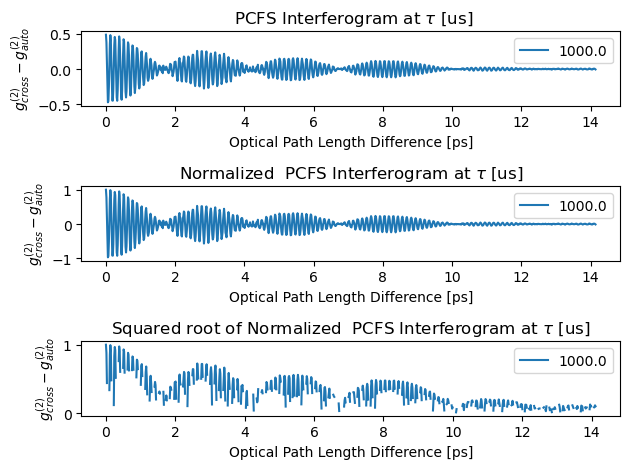

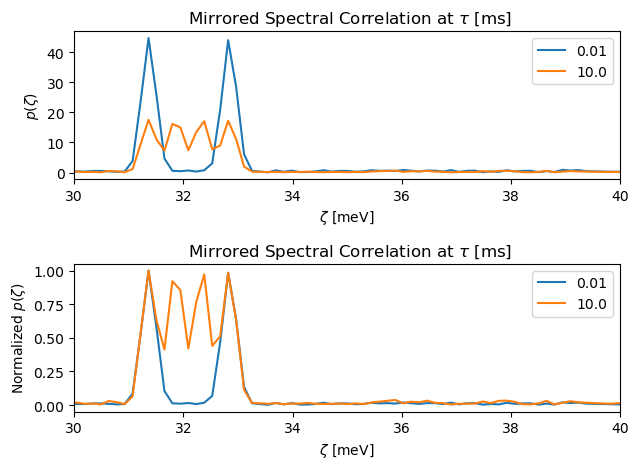

In [5]:
#%%
pcfs1.get_blinking_corrected_PCFS()

pcfs1.plot_spectral_diffusion([1e9], 0)

pcfs1.get_mirror_spectral_corr(0, 0)
pcfs1.get_splev_mirror_spec_corr( 0, 0)
pcfs1.plot_splev_spec_corr([1e7,1e10],(30,40))

In [6]:

#pcfs1.plot_splev_spec_corr([1e2,1e3,1e4],(-50,50))
spectral_corr_file = '/global/scratch/projects/co_utzatgroup/ccobbbruno/24_05_14_multiplexing_with_fewer_stagepositions/anticorrelated_spectral_corr_data_linewidth_1.5_jumping_6_4.txt'
zeta_file = '/global/scratch/projects/co_utzatgroup/ccobbbruno/24_05_14_multiplexing_with_fewer_stagepositions/anticorrelated_zeta_data_linewidth_1.5_jumping_6_4.txt'
tau_file = '/global/scratch/projects/co_utzatgroup/ccobbbruno/24_05_14_multiplexing_with_fewer_stagepositions/anticorrelatedtaus_linewidth_1.5_jumping_6_4.txt'
# Save the data to text files
np.savetxt(spectral_corr_file, pcfs1.splev_spec_corr['spectral_corr'])
np.savetxt(zeta_file, pcfs1.splev_spec_corr['zeta'])
np.savetxt(tau_file, pcfs1.tau)


In [3]:
print(pcfs1.splev_spec_corr['spectral_corr'])

NameError: name 'pcfs1' is not defined

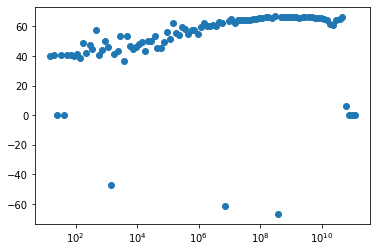

total run time: 21.04285478591919


In [10]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
def lorenzian(x, x0, gamma, A):
    return A * (gamma / ((x - x0) ** 2 + gamma ** 2) / np.pi)

fwhm_arr = []
for i in range(len(pcfs1.tau)):
    y = pcfs1.splev_spec_corr['spectral_corr'][i,:]/max(pcfs1.splev_spec_corr['spectral_corr'][i,:])
    x = pcfs1.splev_spec_corr['zeta']
    try:
        params, covariance = curve_fit(gaussian, x, y)
    except RuntimeError:
        fwhm_arr.append(0)
    else:
        #for lorenzian
        #fwhm = 2 * params[1] 
        #for gaussian
        fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
        fwhm_arr.append(fwhm)
       # plt.plot(x, y, 'bo', label='Data')
        #plt.plot(x, gaussian(x, *params), 'r-', label='Fit')
        #plt.legend()
        
       # plt.show()

#%%
plt.scatter(pcfs1.tau,fwhm_arr, label='Scatter Plot on Log Scales')
plt.xscale('log')
#plt.xlim(1e4,1e11)
#plt.ylim(.5,2)
plt.show()
total_end = timing.time()
print(f'total run time: {total_end-total_start}')

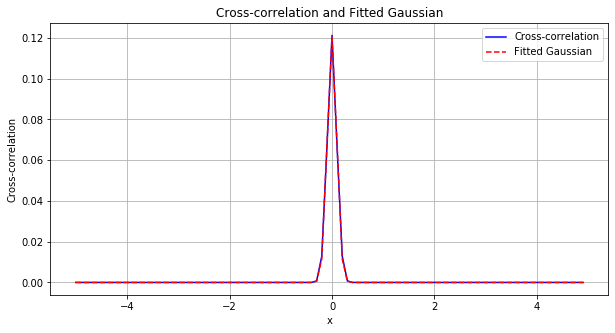

FWHM undiffused: -0.21711864722164712
Standard deviation of the fitted Gaussian: -0.09220180016719431


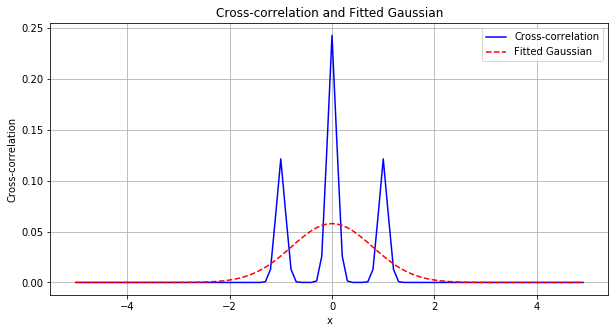

FWHM diffused: 1.861563633062661
Standard deviation of the fitted Gaussian: 0.7905332880917423
% undiffused is -11.663240695374006
% undiffused is -11.663240695374006


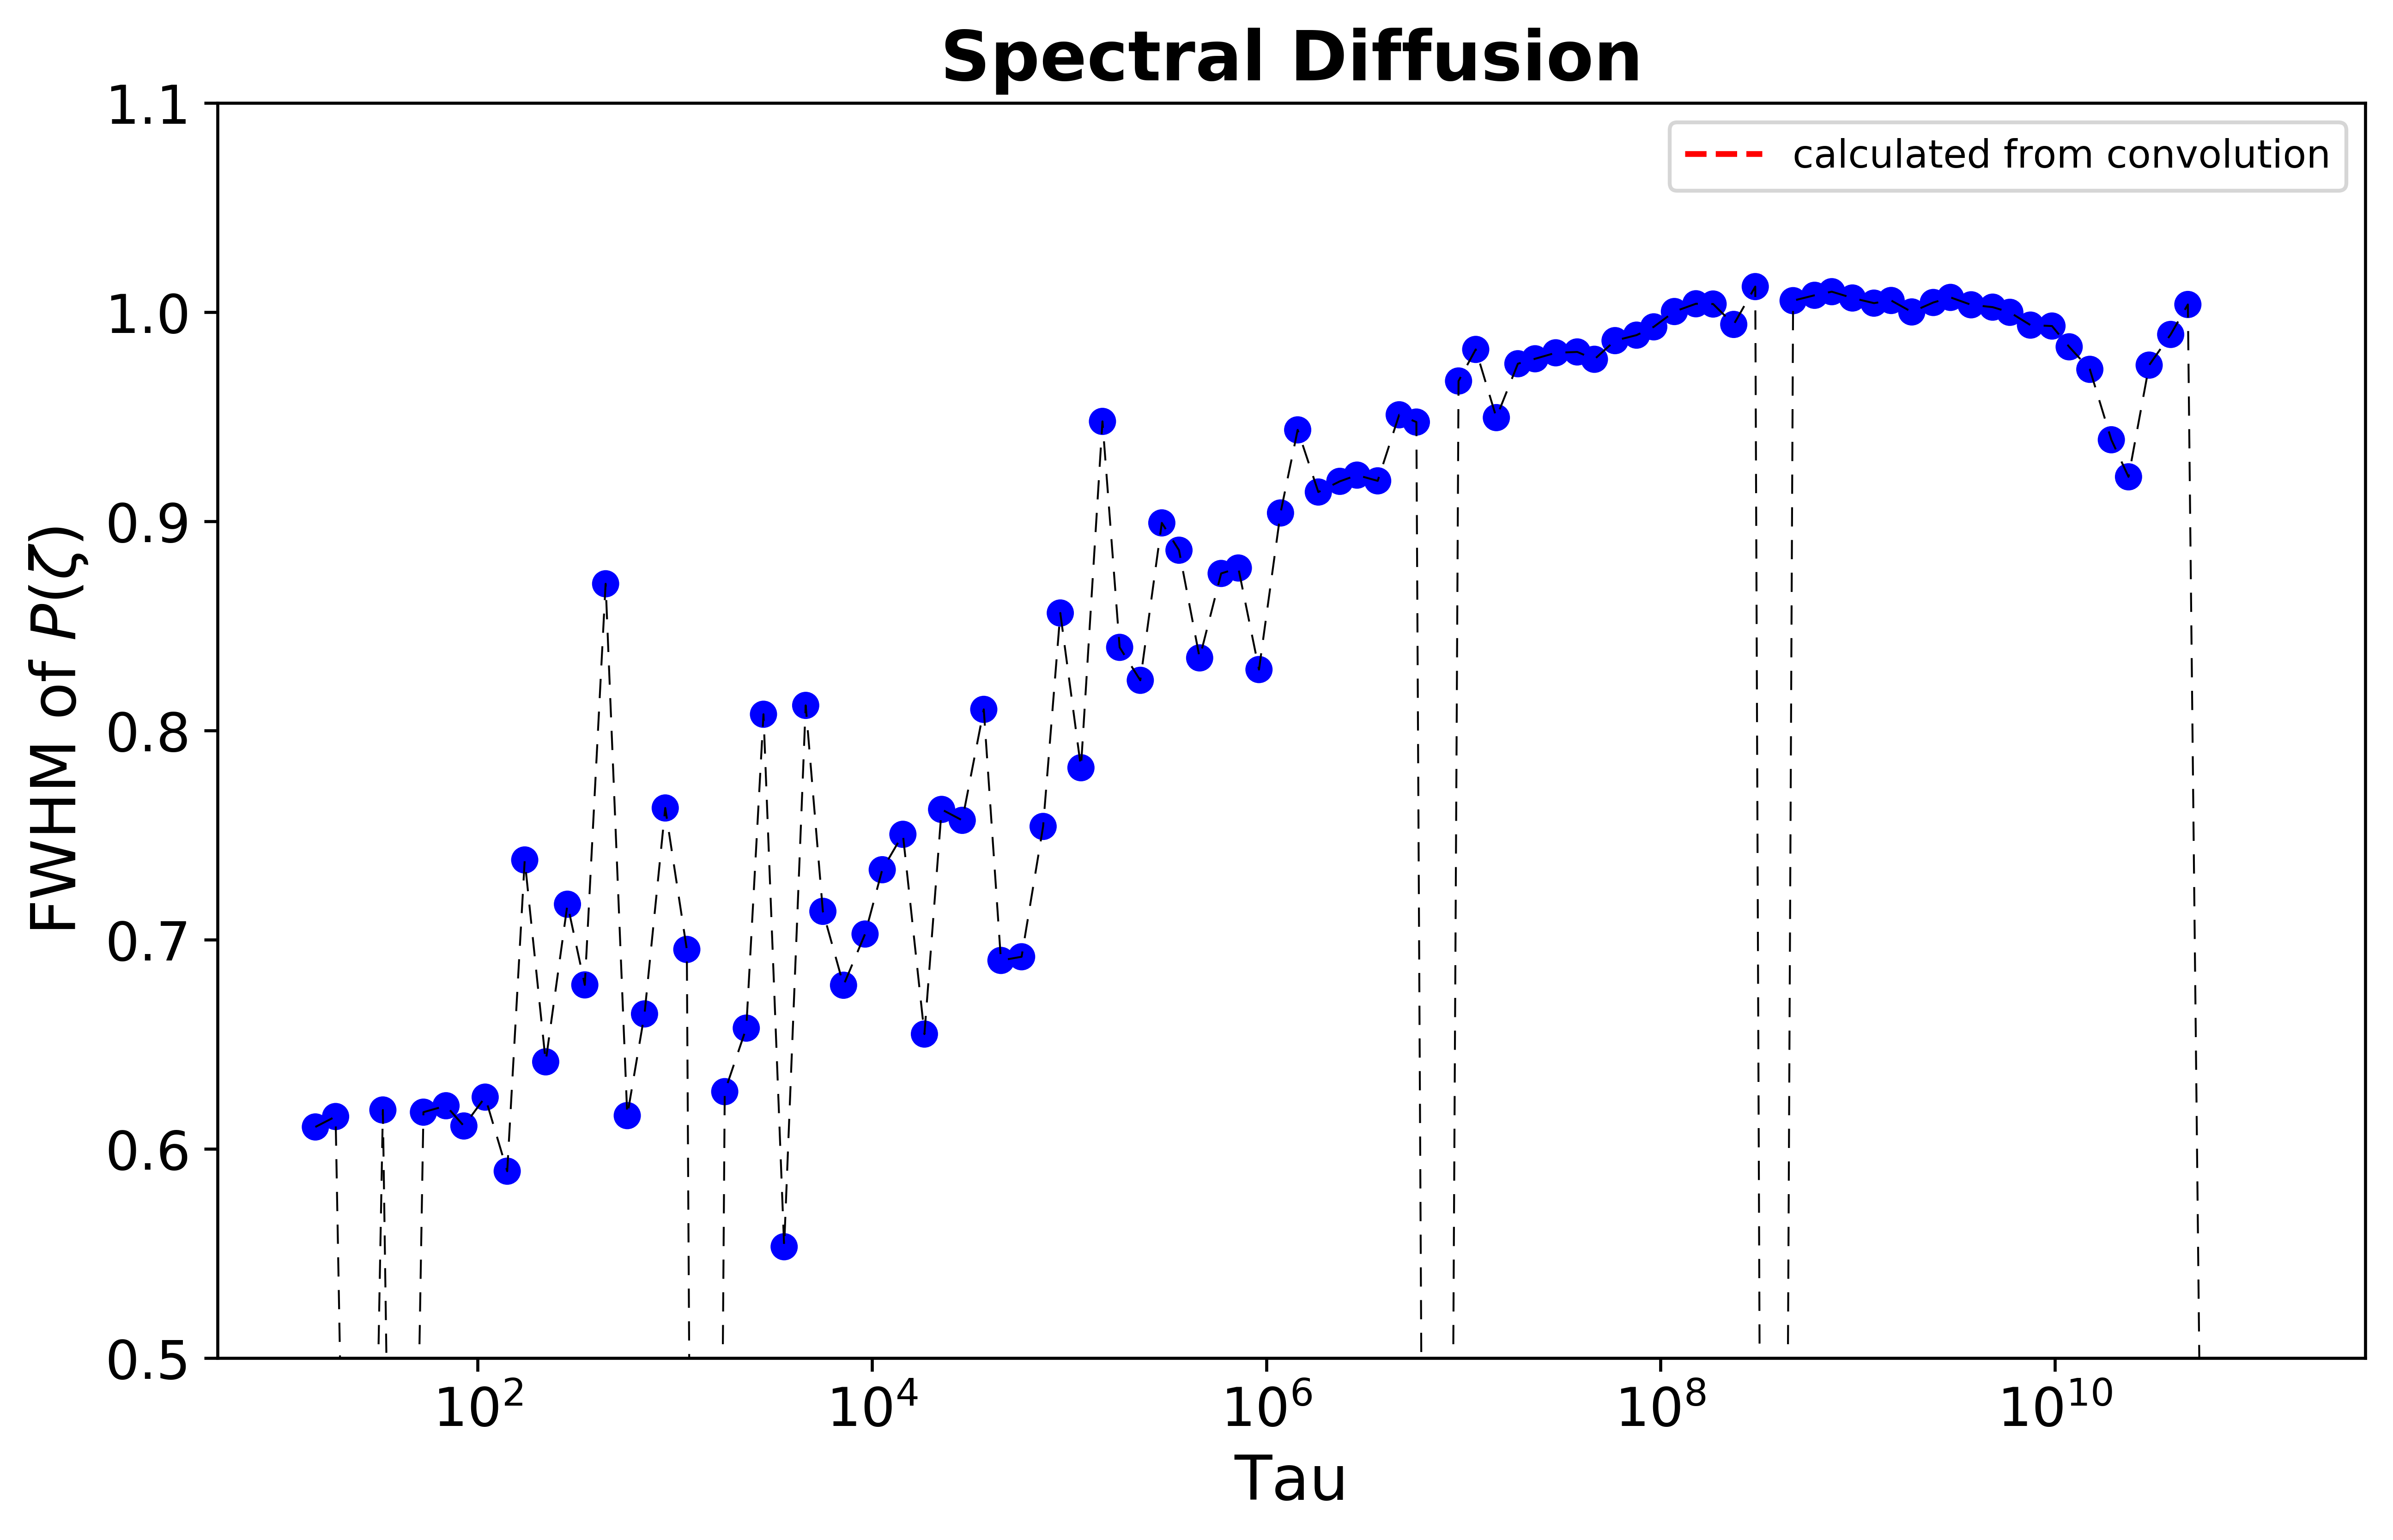

<function print>